# Computer Vision

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import load_sample_image

china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255

2023-10-05 20:18:15.122137: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-05 20:18:15.505629: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-05 20:18:15.508204: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-05 20:18:16.648964: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

In [3]:
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # horizontal line

In [4]:
outputs = tf.nn.conv2d(images, filters, strides=3, padding="SAME")

2023-10-05 20:18:20.370494: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-05 20:18:20.382726: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


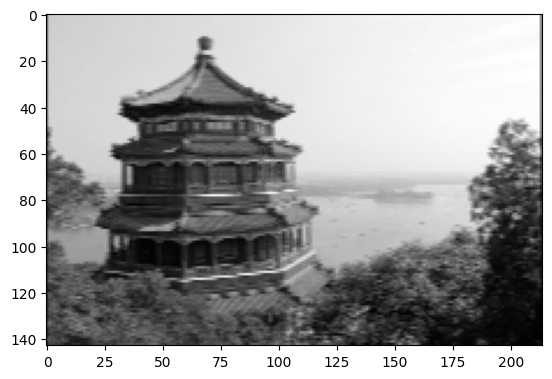

In [5]:
import matplotlib.pyplot as plt

plt.imshow(outputs[0, :, :, 1], cmap="gray")


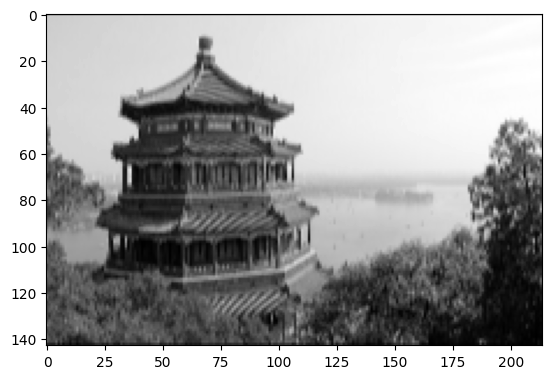

In [6]:
plt.imshow(outputs[0, :, :, 0], cmap="gray")

In [7]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                          padding="same", activation="relu")

In [8]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [9]:
output = tf.nn.max_pool(images, ksize=(1, 1, 1, 3), strides=(1,1,1,3), padding="VALID")

In [10]:
depth_pool = keras.layers.Lambda(
    lambda X: tf.nn.max_pool(X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))

In [11]:
global_avg_pool = keras.layers.GlobalAvgPool2D()

In [12]:
global_avg_pool = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))

# CNN Architectures

In [13]:
# CNN for Fashion MNIST

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=7, activation="relu", padding="same", input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

# ResNet-34 CNN

In [24]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides,
                                padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=strides,
                                padding="same", use_bias=False),
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides,
                                padding="same", use_bias=False),
                keras.layers.BatchNormalization()
            ]
            
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        Z_skip = inputs
        for layer in self.skip_layers:
            Z_skip = layer(Z_skip)
        return self.activation(Z + Z_skip)

In [26]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[224, 224, 3],
                             padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64

for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

ValueError: Exception encountered when calling layer "residual_unit_31" (type ResidualUnit).

in user code:

    File "/tmp/ipykernel_551/1834799886.py", line 29, in call  *
        return self.activation(Z + Z_skip)

    ValueError: Dimensions must be equal, but are 14 and 28 for '{{node residual_unit_31/add}} = AddV2[T=DT_FLOAT](residual_unit_31/batch_normalization_79/FusedBatchNormV3, residual_unit_31/batch_normalization_80/FusedBatchNormV3)' with input shapes: [?,14,14,128], [?,28,28,128].


Call arguments received by layer "residual_unit_31" (type ResidualUnit):
  • inputs=tf.Tensor(shape=(None, 56, 56, 64), dtype=float32)

In [27]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102967424/102967424 [==============================] - 28s 0us/step


In [29]:
images_resized = tf.image.resize(images, [224, 224])

In [30]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

In [31]:
Y_proba = model.predict(inputs)

1/1 [==============================] - 1s 645ms/step


In [32]:
Y_proba

array([[2.0924679e-08, 6.2120350e-08, 3.4899770e-08, ..., 3.0701213e-09,
        1.3317374e-07, 8.0284742e-08],
       [5.9666284e-08, 4.5356690e-05, 2.2303689e-07, ..., 3.2242646e-05,
        2.9164748e-03, 1.0851701e-05]], dtype=float32)

In [34]:
np.argmax(Y_proba, axis=1)

array([442, 599])

In [35]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)

35363/35363 [==============================] - 0s 1us/step


In [36]:
top_K

[[('n02825657', 'bell_cote', 0.8234569),
  ('n03877845', 'palace', 0.067526385),
  ('n03781244', 'monastery', 0.041879054)],
 [('n03530642', 'honeycomb', 0.49813014),
  ('n13040303', 'stinkhorn', 0.33957863),
  ('n02206856', 'bee', 0.043453258)]]

In [38]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /home/mihnea/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [40]:
test_split, valid_split, train_split = tfds.Split.TRAIN.subsplit([10, 15, 75])

test_set = tfds.load("tf_flowers", split=test_split, as_supervised=True)
valid_set = tfds.load("tf_flowers", split=valid_split, as_supervised=True)
train_set = tfds.load("tf_flowers", split=train_split, as_supervised=True)

AttributeError: 'Split' object has no attribute 'subsplit'

In [42]:
n_classes = 10
optimizer = keras.optimizers.legacy.SGD(lr=0.2, momentum=0.9, decay=0.01)

base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)

model = keras.Model(inputs=base_model.input, outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
             loss_weights=[0.8, 0.2],
             optimizer=optimizer, metrics=["accuracy"])

/home/mihnea/personal/ai/env/lib/python3.10/site-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


83683744/83683744 [==============================] - 21s 0us/step


# Exercises

# 1. MNIST using CNN

In [43]:
 (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

In [ ]:
X_train_full = X_train_full / 255
X_test = X_test / 255

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]